Trial 5 Complete [00h 21m 03s]
val_loss: 0.0013824665802530944

Best val_loss So Far: 0.0008549981575924903
Total elapsed time: 02h 43m 47s
Epoch 1/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 2/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 9.4610e-04 - val_loss: 0.0040
Epoch 3/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 8.3951e-04 - val_loss: 0.0032
Epoch 4/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 5/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - loss: 4.6918e-04 - val_loss: 0.0013
Epoch 6/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 3.3893e-04 - val_loss: 0.0020
Epoch 7/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - loss: 7.1672e-04 - val_loss: 0.0022
Epoch 8/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 3.0468e-04 - val_loss: 0.0053
Epoch 9/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 4.5130e-04 - val_loss: 0.0023
Epoch 10/50
725/725 ━━━━━━━━━━━━━━━━━━━━

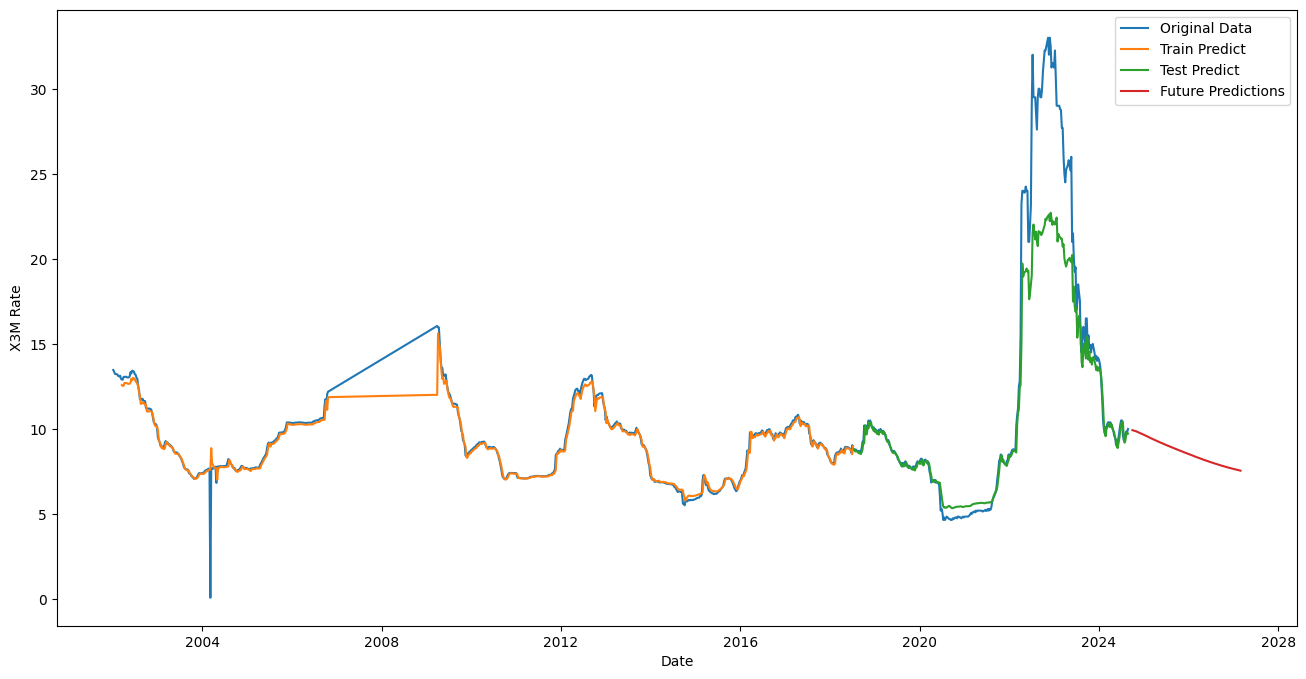

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import keras_tuner as kt

# Load your data
data = pd.read_csv('E:\sem5 project\Sri Lanka 6-Month Bond Yield Historical Data.csv')
data = data.iloc[::-1].reset_index(drop=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Price']]  # Select the X3M column
data = data.dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the time step
time_step = 10

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

# Create the TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(train_data, train_data, length=time_step, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=time_step, batch_size=1)

# Define the model-building function with Bidirectional LSTM
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(time_step, 1)
    )))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=False
    )))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='bidirectional_lstm_tuning'
)

# Run the tuner
tuner.search(train_generator, epochs=50, validation_data=test_generator)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Make predictions for the training and testing data
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)

# Inverse transform the predictions to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the y_train and y_test to get actual values
y_train = scaler.inverse_transform(train_data[time_step:])
y_test = scaler.inverse_transform(test_data[time_step:])

# Function to predict future interest rates
def predict_future(model, data, time_step, future_steps):
    predictions = []
    last_sequence = data[-time_step:]
    
    for _ in range(future_steps):
        # Prepare the input data
        input_data = last_sequence.reshape((1, time_step, 1))
        
        # Predict the next value
        predicted_value = model.predict(input_data)
        
        # Store the predicted value
        predictions.append(predicted_value[0, 0])
        
        # Update the last_sequence
        last_sequence = np.append(last_sequence[1:], predicted_value, axis=0)
    
    return predictions

# Predict future interest rates for the next 12 months (or any desired future period)
future_steps = 30
future_predictions = predict_future(model, scaled_data, time_step, future_steps)

# Inverse transform the future predictions to get actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare the data for plotting
train_predict_index = range(time_step, time_step + len(train_predict))
test_predict_index = range(len(train_predict) + (time_step * 2) + 1, len(scaled_data) - 1)
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='M')[1:]
future_data = pd.DataFrame(future_predictions, index=future_dates, columns=['Future Predictions'])

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(data.index[train_predict_index], train_predict, label='Train Predict')
plt.plot(data.index[-len(test_predict):], test_predict, label='Test Predict')
plt.plot(future_data.index, future_data, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('X3M Rate')
plt.legend()
plt.show()
